In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

log = logging.getLogger(__name__)

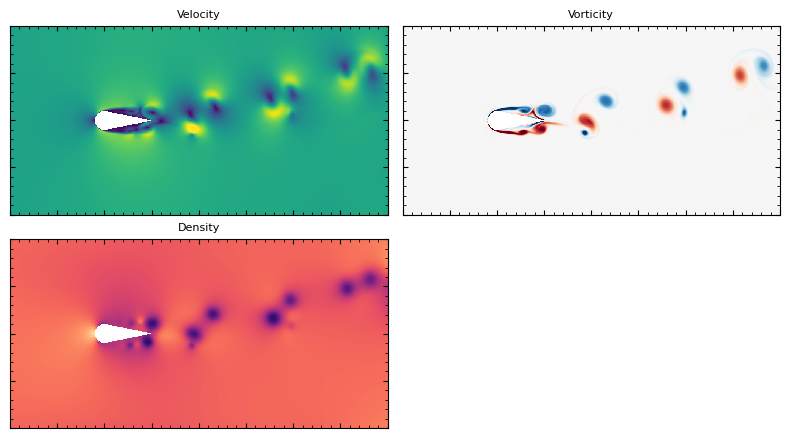

In [2]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy


def load_vti(path: str, what: str | list[str]) -> dict[str, np.ndarray]:
    match what:
        case str():
            what = [what]
        case list():
            pass
        case _:
            raise TypeError()

    img = vtk.vtkXMLImageDataReader()
    img.SetFileName(path)
    img.Update()

    out = img.GetOutput()
    row, col, _ = out.GetDimensions()
    ptd = out.GetPointData()

    def load_dat(what: str):
        dat = vtk_to_numpy(ptd.GetScalars(what))
        cmp = 1 if np.ndim(dat) == 1 else dat.shape[1]
        dat = dat.reshape((col, row, cmp))[1:-1, 1:-1]
        return dat

    return {w: load_dat(w) for w in what}


def do_plot(i: int, show: bool = False):
    path = f"./vortex_street/out_{i:06d}.vti"

    data = load_vti(path, ["Vorticity", "Density", "Velocity", "CellType"])

    vort = data["Vorticity"]
    rho = data["Density"]
    vel = data["Velocity"]
    cell = data["CellType"].astype(np.int8)
    vmag = np.sqrt(np.sum(vel**2, axis=-1))

    vort = np.squeeze(vort)
    rho = np.squeeze(rho)
    vel = np.squeeze(vel)
    cell = np.squeeze(cell)

    vmag = np.where(cell == 1, np.nan, vmag)
    rho = np.where(cell == 1, np.nan, rho)
    vort = np.where(cell == 1, np.nan, vort)

    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    # ax4 = fig.add_subplot(2, 2, 4)

    def _config_axes(ax):
        ax.tick_params(direction="in", which="both", top=True, right=True)
        ax.minorticks_on()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    _config_axes(ax1)
    _config_axes(ax2)
    _config_axes(ax3)
    # _config_axes(ax4)

    e = [-0.2, 0.2, -0.1, 0.1]

    x = np.linspace(e[0], e[1], rho.shape[1])
    y = np.linspace(e[2], e[3], rho.shape[0])
    xx, yy = np.meshgrid(x, y)

    vmin, vmax = 0, 8.6e-2
    ax1.imshow(
        vmag,
        vmin=vmin,
        vmax=vmax,
        cmap=plt.cm.viridis,
        origin="lower",
        extent=e,
        interpolation="none",
    )
    # ax1.contour(xx, yy, vmag, np.linspace(vmin, vmax, 8), colors="k", linewidths=0.5)
    ax1.set_title("Velocity", fontsize=8)

    vmin, vmax = -20, 20
    ax2.imshow(
        vort, vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu, origin="lower", extent=e, interpolation="none"
    )
    # ax2.contour(xx, yy, vort, np.linspace(vmin, vmax, 8), colors="k", linewidths=0.5)
    ax2.set_title("Vorticity", fontsize=8)

    vmin, vmax = 970, 1015
    ax3.imshow(
        rho, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, origin="lower", extent=e, interpolation="none"
    )
    # ax3.contour(xx, yy, rho, np.linspace(vmin, vmax, 8), colors="k", linewidths=0.5)
    ax3.set_title("Density", fontsize=8)
    fig.tight_layout()

    if not show:
        fig.savefig(f"tmp/out_{i:06d}.png", dpi=300)
        fig.clear()
        plt.close()


do_plot(800, show=True)

In [5]:
import multiprocessing as mp
import os

todo = [i for i in range(1000) if not os.path.exists(f"tmp/out_{i:06d}.png")]

with mp.Pool(mp.cpu_count() - 2) as pool:
    _ = pool.map(do_plot, todo)

In [3]:
[i for i in range(1000) if not os.path.exists(f"tmp/out_{i:06d}.png")]

NameError: name 'os' is not defined

In [6]:
import subprocess as sp

sp.call("ffmpeg -r 30 -i tmp/out_%06d.png -c:v libx264 -crf 0 -y example2a.mp4 ", shell=True)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

In [31]:
# params
# dom = DomainMeta.with_extent_and_counts(extent=[[-1, 1], [-1, 1.1]], counts=[200, 220])
dom = DomainMeta.with_extent_and_counts(extent=[[-2, 2], [-1, 1]], counts=[400, 200])
fld = FluidMeta(mu=0.01, rho=100)
sim = SimulationMeta(domain=dom, fluid=fld, dt=0.01)
# sim = SimulationMeta(domain=dom, fluid=fld, dt=0.001)

log.info(f"{dom.dx=}, {dom.extent=}, {dom.counts=}, cells={np.prod(dom.counts):,d}")
log.info(f"{fld.mu=}, {fld.rho=}, {fld.nu=}")
log.info(f"{sim.tau=}, {sim.c=}")

pidx = PeriodicDomain(dom.counts)
params = Params(sim.dt, dom.dx, sim.c, sim.tau)
d2q9 = NumbaModel(D2Q9.ws, D2Q9.qs, D2Q9.js, dom.counts)

2024-05-20 22:02:25,933 - INFO  - [2561078384] dom.dx=0.01, dom.extent=array([[-2,  2],
       [-1,  1]]), dom.counts=array([400, 200], dtype=int32), cells=80,000
2024-05-20 22:02:25,937 - INFO  - [2561078384] fld.mu=0.01, fld.rho=100, fld.nu=0.0001
2024-05-20 22:02:25,938 - INFO  - [2561078384] sim.tau=0.53, sim.c=1.0


In [38]:
# initialize arrays
f = make_array(pidx, 9)
v = make_array(pidx, 2)
cell = make_array(pidx, dtype=np.int32)
rho = make_array(pidx, fill=fld.rho)
# rho *= 1 + 0.01 * np.random.uniform(size=rho.shape)
curl = make_array(pidx)
feq = np.zeros_like(f)

xx, yy = np.meshgrid(dom.x, dom.y)

xx = xx.flatten()
yy = yy.flatten()

# --- Cylinder
cell[:] = CellType.BC_WALL.value * (((xx - -1.0) ** 2 + (yy - 0.0) ** 2) < 0.2**2.0)

# --- In-flow jet
# cell[1, :150] = CellType.BC_WALL.value
# cell[1, -150:] = CellType.BC_WALL.value
# cell[1, 150:-150] = CellType.FIXED_VELOCITY.value
# v[:, 150:-150, 0] = sim.c * 0.1

cell[make_slice_y1d(pidx, 1)] = CellType.FIXED_VELOCITY.value
v[:, 0] = sim.c * 0.1

# v[((xx - -1.5) ** 2 + (yy - 0.0) ** 2) < 0.2**2.0, 0] = sim.c * 0.1
# v[((xx - -1.2) ** 2 + (yy - 0.0) ** 2) < 0.2**2.0, 1] = sim.c * 0.02

In [39]:
import vtk
import vtk.util.numpy_support as vtk_np

from itertools import product


def write_vti(
    path: str,
    dom: PeriodicDomain,
    params: Params,
    v: np.ndarray,
    rho: np.ndarray,
    curl: np.ndarray,
    cell: np.ndarray,
    f: np.ndarray,
):

    counts = dom.counts

    # need 3d vectors for vtk
    def _to3d(v: np.ndarray):
        if v.shape[-1] == 2:
            return np.pad(v, [(0, 0), (0, 1)])
        else:
            return v

    # reshape data for writing
    v_T = np.reshape(_to3d(v), list(counts) + [3])
    rho_T = np.reshape(rho, list(counts))
    curl_T = np.reshape(curl, list(counts))
    cell_T = np.reshape(cell, list(counts))
    f_T = np.reshape(f, list(counts) + [9])

    # v_T[cell_T == CellType.BC_WALL.value, :] = np.nan
    # rho_T[cell_T == CellType.BC_WALL.value] = np.nan
    # curl_T[cell_T == CellType.BC_WALL.value] = np.nan

    # cut off periodic part
    # xidx = np.arange(1, counts[0] - 1, 1, dtype=np.int32)
    # yidx = np.arange(1, counts[1] - 1, 1, dtype=np.int32)
    # idx = np.array(list(product(xidx, yidx)), dtype=np.int32)

    # v_T = v_T[idx, :]
    # rho_T = rho_T[idx]
    # curl_T = curl_T[idx]
    # cell_T = cell_T[idx]

    image_data = vtk.vtkImageData()
    nx, ny = list(counts)
    image_data.SetDimensions(nx, ny, 1)

    rho_data = vtk_np.numpy_to_vtk(num_array=rho_T.ravel(), deep=False, array_type=vtk.VTK_FLOAT)
    rho_data.SetName("Density")
    rho_data.SetNumberOfComponents(1)

    vel_data = vtk_np.numpy_to_vtk(num_array=v_T.ravel(), deep=False, array_type=vtk.VTK_FLOAT)
    vel_data.SetName("Velocity")
    vel_data.SetNumberOfComponents(3)

    curl_data = vtk_np.numpy_to_vtk(num_array=curl_T.ravel(), deep=False, array_type=vtk.VTK_FLOAT)
    curl_data.SetName("Vorticity")
    curl_data.SetNumberOfComponents(1)

    wall_data = vtk_np.numpy_to_vtk(num_array=cell_T.ravel(), deep=False, array_type=vtk.VTK_FLOAT)
    wall_data.SetName("CellType")
    wall_data.SetNumberOfComponents(1)

    p_data = image_data.GetPointData()
    p_data.AddArray(rho_data)
    p_data.AddArray(vel_data)
    p_data.AddArray(curl_data)
    p_data.AddArray(wall_data)

    f_data = vtk_np.numpy_to_vtk(num_array=f_T.ravel(), deep=False, array_type=vtk.VTK_FLOAT)
    f_data.SetName(f"F")
    f_data.SetNumberOfComponents(9)
    p_data.AddArray(f_data)

    p_data.SetActiveAttribute("Velocity", vtk.VTK_ATTRIBUTE_MODE_DEFAULT)

    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(path)
    writer.SetInputData(image_data)
    writer.Write()


write_vti("out/example2_{out_i:06d}.vti".format(out_i=0), pidx, params, v, rho, curl, cell, f)

In [46]:
@numba.njit(
    numba.float64(numba.float64, PeriodicDomain.class_type.instance_type),
)
def myfunc(x, pidx: PeriodicDomain):
    return x + pidx.counts[0]


myfunc(10.0, pidx)

412.0

In [40]:
calc_equilibrium(v, rho, f, np.float32(params.cs), d2q9.ws, d2q9.qs)

In [41]:
# main loop
t = 0.0
out_dt = 0.01
# out_dt = sim.dt
out_i = 1
out_t = out_dt
max_i = 300

batch_i = int((out_dt + 1e-8) // sim.dt)

log.info(f"{batch_i:,d} iters/output")

wall = (cell == CellType.BC_WALL.value).astype(np.int32)
update_vel = (cell == CellType.FLUID.value).astype(np.int32)
gumpf = (d2q9.ws, d2q9.qs, d2q9.qs_f32, d2q9.js, d2q9.os, params.dx, params.tau, params.cs)

# call once to run jit ...
loop_for(v, rho, curl, cell, f, feq, pidx.counts, 0, *gumpf)

# f[:, :] = 0
# f[((xx - -1.2) ** 2 + (yy - 0.0) ** 2) < 0.2**2.0, :] = 5
# feq = np.copy(f)

write_vti("out/example2_{out_i:06d}.vti".format(out_i=0), pidx, params, v, rho, curl, cell, f)


prog_msg = "Wrote out_i={out_i} out_t={out_t:.3f}, mlups_batch={mlups_batch:.2f}, mlups_total={mlups_total:.2f}\r".format
perf_total = PerfInfo()

for out_i in range(1, max_i):
    perf_batch = tick()

    loop_for(v, rho, curl, cell, f, feq, pidx.counts, batch_i, *gumpf)

    perf_batch = perf_batch.add_events(np.prod(dom.counts) * batch_i).tock()
    perf_total = perf_total + perf_batch

    mlups_batch = perf_batch.events / (1e6 * perf_batch.seconds)
    mlups_total = perf_total.events / (1e6 * perf_total.seconds)

    log.info(prog_msg(out_i=out_i, out_t=out_t, mlups_batch=mlups_batch, mlups_total=mlups_total))

    write_vti(
        "out/example2_{out_i:06d}.vti".format(out_i=out_i), pidx, params, v, rho, curl, cell, f
    )
    out_t += out_dt

2024-05-20 22:03:29,689 - INFO  - [4143085392] 1 iters/output


2024-05-20 22:03:29,856 - INFO  - [4143085392] Wrote out_i=1 out_t=0.010, mlups_batch=1.24, mlups_total=1.24
2024-05-20 22:03:30,003 - INFO  - [4143085392] Wrote out_i=2 out_t=0.020, mlups_batch=1.16, mlups_total=1.20
2024-05-20 22:03:30,178 - INFO  - [4143085392] Wrote out_i=3 out_t=0.030, mlups_batch=0.89, mlups_total=1.08
2024-05-20 22:03:30,321 - INFO  - [4143085392] Wrote out_i=4 out_t=0.040, mlups_batch=1.24, mlups_total=1.11
2024-05-20 22:03:30,450 - INFO  - [4143085392] Wrote out_i=5 out_t=0.050, mlups_batch=1.22, mlups_total=1.13
2024-05-20 22:03:30,569 - INFO  - [4143085392] Wrote out_i=6 out_t=0.060, mlups_batch=1.33, mlups_total=1.16
2024-05-20 22:03:30,694 - INFO  - [4143085392] Wrote out_i=7 out_t=0.070, mlups_batch=1.40, mlups_total=1.19
2024-05-20 22:03:30,821 - INFO  - [4143085392] Wrote out_i=8 out_t=0.080, mlups_batch=1.24, mlups_total=1.20
2024-05-20 22:03:30,947 - INFO  - [4143085392] Wrote out_i=9 out_t=0.090, mlups_batch=1.36, mlups_total=1.21
2024-05-20 22:03:31

KeyboardInterrupt: 

In [ ]:
stream(feq, f, wall)

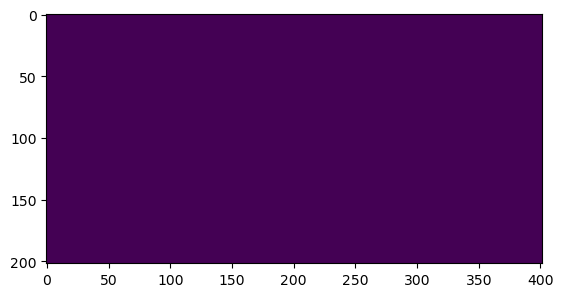

In [42]:
plt.imshow(np.sum(unflatten(pidx, v) ** 2, -1).T)

In [44]:
f

array([[43.77778  , 14.777779 , 10.944445 , ...,  2.027778 ,  2.027778 ,
         3.6944447],
       [43.77778  , 14.777779 , 10.944445 , ...,  2.027778 ,  2.027778 ,
         3.6944447],
       [43.77778  , 14.777779 , 10.944445 , ...,  2.027778 ,  2.027778 ,
         3.6944447],
       ...,
       [43.77778  , 14.777779 , 10.944445 , ...,  2.027778 ,  2.027778 ,
         3.6944447],
       [43.77778  , 14.777779 , 10.944445 , ...,  2.027778 ,  2.027778 ,
         3.6944447],
       [43.77778  , 14.777779 , 10.944445 , ...,  2.027778 ,  2.027778 ,
         3.6944447]], dtype=float32)

In [7]:
import numba
import numba.cuda as cuda

In [9]:
@cuda.jit
def my_kernel(arr: np.ndarray):
    txidx = cuda.threadIdx.x
    bxidx = cuda.blockIdx.x
    bxcnt = cuda.blockDim.x
    idx = bxidx * bxcnt + txidx
    arr[idx] += 1


arr = np.random.randint(0, 10, size=(3200,))

blocks = 100
threads_per_block = 32
my_kernel[blocks, threads_per_block](arr)

/root/anaconda3/envs/boltzmann/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [10]:
cuda.is_available()

False

21.0


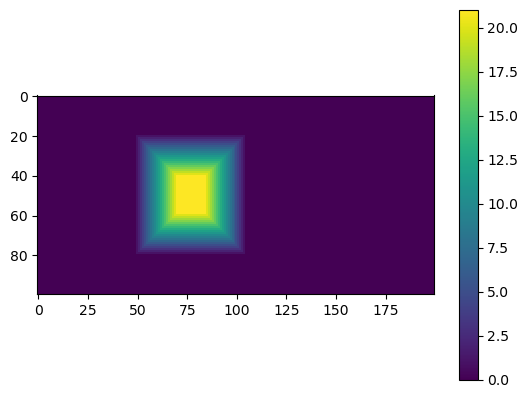

In [62]:
wall = np.zeros((100, 200))
wall[40:60, 70:85] = 1

from scipy.signal import convolve2d


def expand_1(arr):
    K = np.array([1, 1, 1])
    KK = np.outer(K, K)
    return 1 * (convolve2d(arr, KK, mode="same") > 0)


def dist_d(arr, d: int):
    res = np.copy(arr)
    raw = np.copy(arr)
    for _ in range(d):
        raw = expand_1(res)
        res += raw
    return res


# wall_ = wall
# wall_ += expand_1(wall)
wall_ = dist_d(wall, 20)

plt.imshow(wall_, interpolation="none")
plt.colorbar()

print(wall_.max())

70.71067811865476


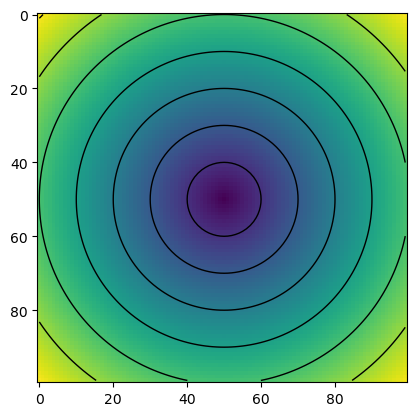

In [141]:
wall = np.zeros((100, 100))
# wall[40:60, 70:85] = 1
wall[50, 50] = 1

from scipy.signal import convolve2d


qs = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [0, -1],
        [-1, 0],
        [1, 1],
        [1, -1],
        [-1, 1],
        [-1, -1],
    ]
)

r = np.sqrt(2)
ds = [0, 1, 1, 1, 1, r, r, r, r]


def _dist_1(DD):
    # KK = np.array(
    #     [
    #         [r, 1, r],
    #         [1, 0, 1],
    #         [r, 1, r],
    #     ]
    # )
    # DD1 = convolve2d(np.isfinite(DD), KK, mode="same", boundary="wrap")
    # return DD + DD1

    FF = np.ones(DD.shape + (9,)) * np.inf
    for i, (q, d) in enumerate(zip(qs, ds)):
        sy = slice(1 + q[0], DD.shape[0] - 1 + q[0])
        sx = slice(1 + q[1], DD.shape[1] - 1 + q[1])
        FF[1:-1, 1:-1, i] = DD[sy, sx] + d

    return np.min(FF, -1)


def dist_d(WW, d: int):
    DD = np.where(WW > 0, 0, np.inf)
    for _ in range(d):
        DD = _dist_1(DD)
    m = np.isfinite(DD)
    DD = np.where(m, DD, DD[m].max())
    return DD


from scipy.ndimage import distance_transform_edt


wall_ = distance_transform_edt(1 - wall)
# wall_ = wall
# wall_ = _dist_1(wall, np.zeros_like(wall))
# wall_ = dist_d(wall, 50)
# wall_ = expand_d(wall, 20)

plt.imshow(wall_, interpolation="none")
plt.contour(wall_, colors="k", linewidths=1)
# plt.colorbar()

print(wall_.max())

In [142]:
for i in range(46, 55):
    print("  ".join(map("{:.01f}".format, wall_[i, 46:55])))

5.7  5.0  4.5  4.1  4.0  4.1  4.5  5.0  5.7
5.0  4.2  3.6  3.2  3.0  3.2  3.6  4.2  5.0
4.5  3.6  2.8  2.2  2.0  2.2  2.8  3.6  4.5
4.1  3.2  2.2  1.4  1.0  1.4  2.2  3.2  4.1
4.0  3.0  2.0  1.0  0.0  1.0  2.0  3.0  4.0
4.1  3.2  2.2  1.4  1.0  1.4  2.2  3.2  4.1
4.5  3.6  2.8  2.2  2.0  2.2  2.8  3.6  4.5
5.0  4.2  3.6  3.2  3.0  3.2  3.6  4.2  5.0
5.7  5.0  4.5  4.1  4.0  4.1  4.5  5.0  5.7


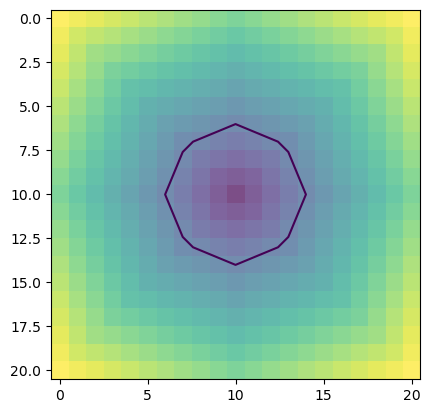

In [136]:
s = slice(40, 61)
plt.imshow(wall_[s, s], alpha=0.7)
plt.contour(wall_[s, s], levels=(4,))